### Complex compartment models
In the last notebook you created a simple stick & ball compartment model. Obviously, neurons from connectomes are much more detailed than that. Here, you will learn how to generate a complex compartment model using the `NEURON` simulator.

For this exercise we will use `navis` to construct a NEURON model for us.

```bash 
pip3 install navis -U
```

First import the usual suspects:

In [13]:
import neuron
import navis

from neuron import h
from neuron.units import ms, mV, µm

h.load_file("stdrun.hoc")

1.0

We will start off by having a quick glances at [navis](https://navis.readthedocs.io/en/latest/): `navis` is the Python counterpart to the popular `nat` library in R. It focusses on neuroanatomical analyses and visualisations of skeletons, meshes and dotprops but including an interface with `NEURON` that abstracts away some of the complexities.

In [15]:
# Load an example neuron (a skeleton) that ships with navis
# This is an olfactory projection neuron from the hemibrain project
n = navis.example_neurons(1)

# Show some stats
n

,
type,navis.TreeNeuron
name,DA1_lPN_R
id,1734350788
n_nodes,4465
n_connectors,2705
n_branches,599
n_leafs,618
cable_length,266476.875
soma,[4177]
units,8 nanometer


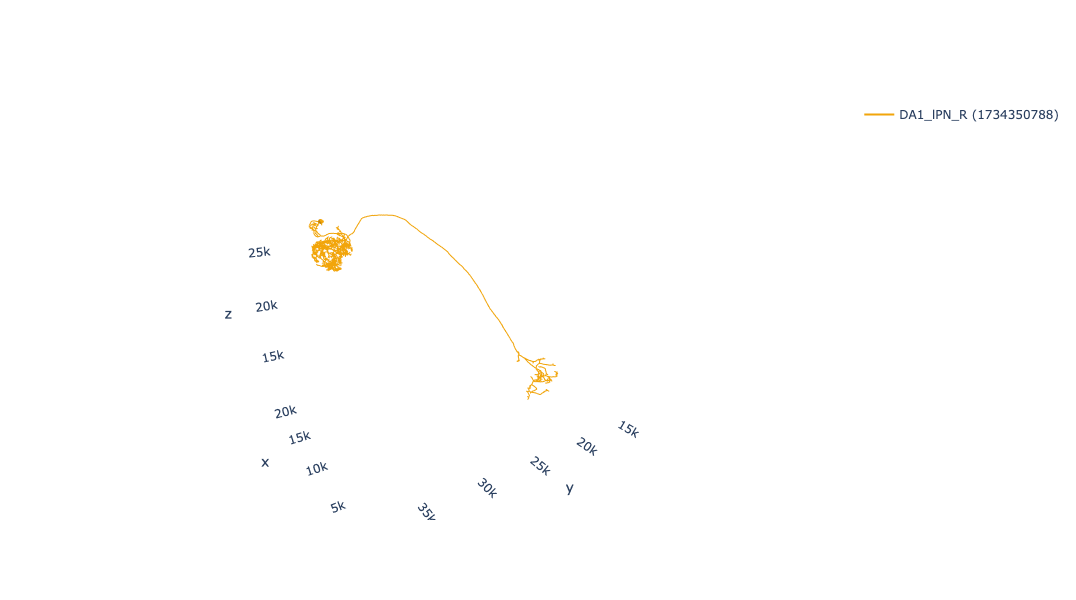

In [17]:
# Plot the neuron
navis.plot3d(n)

Before constructing our model we need to make a few small fixes

In [31]:
n.soma = 20  # Change the soma to a different node 
n.soma_radius = 500  # Change the soma radius to 500nm
n.reroot(n.soma, inplace=True)  # Reroot the skeleton to the soma
_ = n.convert_units('um', inplace=True)  # NEURON expects data in microns

Now we can generate a compartment model

In [32]:
# Create the compartment model
import navis.interfaces.neuron as nrn

cmp = nrn.CompartmentModel(n, res=10)

`CompartmentModel` essentially wraps the `Section` stuff we did manually for the stick & ball model. It also provides some convenient methods to help you setup stimuli, recordings and mechanisms.

Let's add biophysical properties from [Tobin et al. (2017)](https://elifesciences.org/articles/24838):

In [33]:
# Set the specific axial resistivity for the entire neuron in Ohm / cm
cmp.Ra = 266.1

# Set the specific membran capacitance in mF / cm**2
cmp.cm = 0.8

# Add passive membran properties for the entire neuron
cmp.insert('pas',
           g=1/20800,  # specific leakage conductance = 1/Rm; Rm = specific membran resistance in Ohm cm**2
           e=-60       # leakage reverse potential
           )

At this point we already have a passive model of our _Drosophila_ projection neuron. Next, we will determine what’s axon and what’s dendrite, and add a Hodgkins & Huxley mechanism so we have some actual action potentials to observe.

This will also illustrate one of the features of CompartmentModels: we keep a correspondence to the original skeleton via node (and connector) IDs. This allows you to modify, stimulate at or record from parts of the compartment model by using node IDs.

In [34]:
# Label axon/dendrite
navis.split_axon_dendrite(n, label_only=True, cellbodyfiber='soma')

# Inspect the skeleton's node table
n.nodes.head()

,node_id,label,x,y,z,radius,parent_id,type,compartment
0,1,0,126.272003,298.000000,224.496017,0.080000,2,end,cellbodyfiber
1,2,0,126.112007,297.840027,224.656006,0.146274,3,slab,cellbodyfiber
2,3,0,125.952003,297.520020,224.976013,0.277771,4,slab,cellbodyfiber
3,4,0,125.952003,297.200012,225.616013,0.277771,5,slab,cellbodyfiber
4,5,0,125.632004,297.040009,225.936005,0.277771,6,slab,cellbodyfiber


Quickly inspect the result of the axon/dendrite labeling

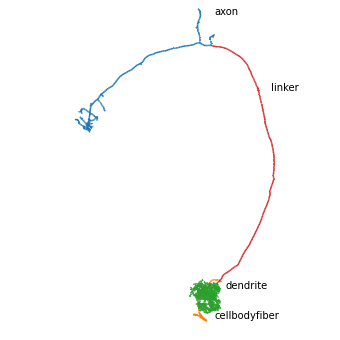

In [36]:
# Make a 2D plot
fig, ax = navis.plot2d(n, color_by='compartment', palette='tab10', soma=False, lw=1.5)

# Label compartments
for l in n.nodes.compartment.unique():
    loc = n.nodes.loc[n.nodes.compartment == l, ['x', 'y', 'z']].values[-1]
    ax.text(loc[0] + 10, loc[1], loc[2], l)

ax.elev = -110

Now we will add active mechanisms to the linker and the axon

In [37]:
# Collect axon nodes
axon_nodes = n.nodes.loc[n.nodes.compartment.isin(['axon', 'linker']), 'node_id'].values

# Get the sections for the given nodes
axon_secs = list(set(cmp.get_node_section(axon_nodes)))

# Insert HH mechanism at the given sections
cmp.insert('hh', subset=axon_secs)

Next, we need will add three voltage recorders: one at the soma, one at the base of the dendrites and one at the tip of the axon.

In [38]:
# Let's determine the tip of the axon and base of the dendrites programmatically using the geodesic distance
dists = navis.geodesic_matrix(n, from_=n.soma)

# Sort by distance from soma
dists = dists.iloc[0].sort_values()

dists.head(10)

20      0.000000
21      0.455753
19      0.633259
2409    0.836538
22      1.095767
18      1.113258
23      1.415775
2410    1.474030
24      1.692905
17      2.032377
Name: 20, dtype: float64

In [39]:
# Find the closest "dendrite" and the most distal "axon" node
dend = n.nodes[n.nodes.compartment == 'dendrite'].node_id.values
dend_base = dists.index[dists.index.isin(dend)][0]
print(f'Node at the base of the dendrites: {dend_base}')

axo = n.nodes[n.nodes.compartment == 'axon'].node_id.values
axo_tip = dists.index[dists.index.isin(axo)][-1]
print(f'Node at the tip of the axon: {axo_tip}')

Node at the base of the dendrites: 467
Node at the tip of the axon: 4384


In [40]:
# Add voltage recordings
cmp.add_voltage_record(dend_base, label='dendrite_base')
cmp.add_voltage_record(axo_tip, label='axon_tip')
cmp.add_voltage_record(n.soma, label='soma')

Last but not least we need to provide some input to our neuron otherwise it will just sit there doing nothing. We can add a current injection, trigger some synaptic currents or add a leak current. Let’s simulate some synaptic inputs:

In [41]:
# Inspect the dendritic postsynapses
post = n.postsynapses[n.postsynapses.compartment == 'dendrite']
post.head()

,connector_id,node_id,type,x,y,z,roi,confidence,compartment
137,137,3736,post,135.232,291.104,210.840,AL(R),0.906454,dendrite
138,138,635,post,132.872,284.448,196.056,AL(R),0.928960,dendrite
139,139,4124,post,131.432,277.048,200.960,AL(R),0.605084,dendrite
140,140,3176,post,124.984,286.568,216.480,AL(R),0.922643,dendrite
219,219,3061,post,128.312,276.848,217.272,AL(R),0.981077,dendrite


In [43]:
# Here we will open successively more synapses over 5 stimulations
for i in range(5):
    # Onset for this stimulation
    start = 50 + i * 200
    # Number of synapses to activate
    n_syn = i * 5
    print(f'Activating {n_syn} synapses at {start}ms')
    cmp.add_synaptic_current(where=post.node_id.unique()[0:n_syn],
                             start=start,
                             max_syn_cond=.1,
                             rev_pot=-10)

Activating 0 at 50ms
Activating 5 at 250ms
Activating 10 at 450ms
Activating 15 at 650ms
Activating 20 at 850ms


In [45]:
%%time

# Now we can run our simulation for 1000ms
# (this is equivalent to `neuron.h.finitialize + neuron.h.continuerun`)
cmp.run_simulation(1000, v_init=-60)

CPU times: user 5.21 s, sys: 35 ms, total: 5.25 s
Wall time: 5.23 s


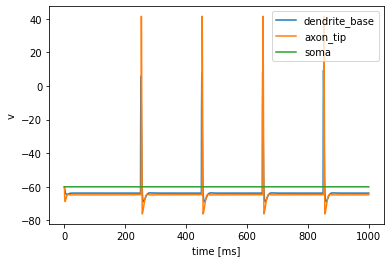

In [46]:
# Plot the results
axes = cmp.plot_results()

(240.0, 280.0)

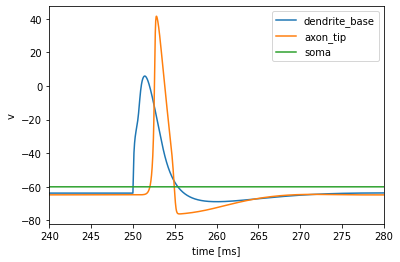

In [47]:
# Plot and zoom in on one spike
axes = cmp.plot_results()
axes[0].set_xlim(240, 280)

As you can see we get a nice depolarization at the base of the dendrites which elicits an action potential that we can measure in the tips of the axon. Because in our model the cell body fiber (i.e. the neurite that connects the soma to the base of the dendrites) is passive, the depolarization of a single spike attenuates before it reaches the soma.

Now you have 15min to play around with the above. Please download this notebook and run on your machine or collaboratory. A couple tasks:

1. Add a spike detector using `cmp.add_spike_detector` at the tip of the axon
2. Reset the model and replace the synaptic current with synaptic input (`cmp.add_synaptic_input`) at 20 postsynapses (`post.node_id.unique()[0:20]`). Play with the number and interval of spikes and add try adding noise.